In [1]:
import requests
from bs4 import BeautifulSoup
import nltk
import re
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json

In [2]:
base_url = 'https://en.wikipedia.org'
r = requests.get(url = "https://en.wikipedia.org/wiki/COVID-19_pandemic")

In [3]:
soup = BeautifulSoup(r.content,'html.parser')

In [4]:
# Get the links and content of the original wiki
links = [i['href'] for i in soup.select('p a[href]') if '#cite' not in i['href'] and 'edit' not in i['href']]
body = str(soup('p',class_=None))
body = re.sub('^.|.$', '', body)
body = BeautifulSoup(body,'html.parser')
content = body.get_text()
content = re.sub('\n|\[.*?\]','',content)
content = re.sub('\xa0',' ',content)
content = re.sub('\.,','.',content)

In [5]:
# Get contents from the links
contents= [content]
for i in links:
    r = requests.get(url = base_url+i)
    soup = BeautifulSoup(r.content,'html.parser')
    body = str(soup('p',class_=None))
    body = re.sub('^.|.$', '', body)
    body = BeautifulSoup(body,'html.parser')
    content = body.get_text()
    content = re.sub('\n|\[.*?\]','',content)
    content = re.sub('\xa0',' ',content)
    content = re.sub('\.,','.',content)
    contents+= [content]

In [6]:
file = open('wikidata.text','w')
file.writelines(contents)
file.close()

In [7]:
def preprocess(data):
    result = []
    nlp = spacy.load("en_core_web_sm",exclude=["parser"])
    nlp.enable_pipe("senter")
    lemmatizer = nlp.get_pipe("lemmatizer")
    stopwords = nlp.Defaults.stop_words
    for i in data:
        doc = nlp(i)
        word = [token.lemma_ for token in doc]
        word = [i.lower() for i in word]
        word = [i for i in word if i not in stopwords]
        result+=word
    return result

In [8]:
# Get tokens from the contents
wikis = preprocess(contents)

In [109]:
freq = nltk.FreqDist(i for i in wikis if re.search('[a-zA-Z]', i) != None)
list(freq.most_common(20))

[('state', 8363),
 ('use', 6056),
 ('include', 5669),
 ('country', 5239),
 ('people', 5236),
 ('government', 4769),
 ('health', 4467),
 ('world', 4358),
 ('new', 4317),
 ('case', 4297),
 ('year', 4221),
 ('china', 4178),
 ('covid-19', 3994),
 ('united', 3703),
 ('day', 3496),
 ('report', 3446),
 ('time', 3249),
 ('million', 3227),
 ('city', 3210),
 ('high', 3181)]

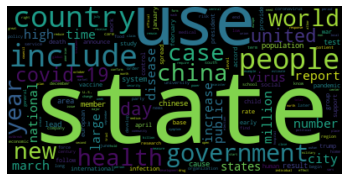

In [30]:
wc = WordCloud()
wc.generate_from_frequencies((dict(freq)))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
with open('data.json') as json_file:
    data = json.load(json_file)

In [12]:
tweets = []
for i in data:
    if 'retweeted_status'in i:
        tweets += [i['retweeted_status']['full_text']]
    else:
        tweets += [i['full_text']]
        
train_data = tweets.copy()[:9000]
test_data = tweets.copy()[9000:]

In [13]:
test_words = preprocess(test_data)

In [36]:
testfreq = nltk.FreqDist(i for i in test_words if re.search('[a-zA-Z]', i) != None)
oov1 = [i for i in list(testfreq) if i not in dict(freq)]

In [38]:
oov2 = [i for i in test_words if i not in dict(freq)]

In [39]:
print('OOV word types of wikidata', len(oov1)/len(testfreq))
print('OOV word tokens of wikidata', len(oov2)/len(test_words))

OOV word types of wikidata 0.33267570900123306
OOV word tokens of wikidata 0.41170843696192844


In [40]:
train_words = preprocess(train_data)

In [41]:
trainfreq = nltk.FreqDist(i for i in train_words if re.search('[a-zA-Z]', i) != None)
oov1 = [i for i in list(testfreq) if i not in dict(trainfreq)]

In [42]:
oov2 = [i for i in test_words if i not in dict(trainfreq)]

In [45]:
print('OOV word types of training tweeter data', len(oov1)/len(testfreq))
print('OOV word tokens of training tweeter data', len(oov2)/len(test_words))

OOV word types of training tweeter data 0.23871763255240444
OOV word tokens of training tweeter data 0.36896881576430074


In [79]:
result = []
nlp = spacy.load("en_core_web_sm",exclude=["parser"])
nlp.enable_pipe("senter")
lemmatizer = nlp.get_pipe("lemmatizer")
stopwords = nlp.Defaults.stop_words
for i in contents[:50]:
    doc = nlp(i)
    sents = [i for i in doc.sents]
    result+=sents

In [96]:
# training data preprocessing
result = result[:9000]
tokens = [nltk.word_tokenize(str(i)) for i in result]
words = [[i.lower() for i in j] for j in tokens]
train,vocab = nltk.lm.preprocessing.padded_everygram_pipeline(3, words)

In [97]:
# treat one tweet: 
#     remove url,@,tag
#     sentence segmentation
#     tokenization
#     word lowercase

def treat(data): 
    temp = re.sub(r'http\S+', '', re.sub(r'@\S+', '', re.sub(r'#\S+', '',data)))
    temp = temp.splitlines()
    temp = [i for i in temp if i!='']
    sents = [nltk.sent_tokenize(i) for i in temp]
    sents = [i for j in sents for i in j]
    tokens = [nltk.word_tokenize(i) for i in sents]
    words = [[i.lower() for i in j] for j in tokens]
    return words

# Padding for list of tweets
# n : n-gram padding
# train: True if data is training data
def pad(data,n,train):
    pad = []
    if train == True:
        vocab = []
        for tweet in data:
            treated =treat(tweet)
            padded = [list(nltk.lm.preprocessing.pad_both_ends(i,n=n)) for i in treated]
            padded = [i for j in padded for i in j]
            ngrams = list(nltk.everygrams(padded,max_len=n))
            pad+=[ngrams]
            vocab+=padded
        return pad, vocab
    else:
        for tweet in data:
            treated = treat(tweet)
            if n == 3:
                temp = [list(nltk.trigrams(nltk.lm.preprocessing.pad_both_ends(i,n=3))) for i in treated]
            elif n == 2:
                temp = [list(nltk.bigrams(nltk.lm.preprocessing.pad_both_ends(i,n=2))) for i in treated]
            else:
                temp = [list(nltk.everygrams(i,max_len=1)) for i in treated]
            temp = [i for j in temp for i in j]
            pad += [temp]
        return pad

In [98]:
# Test data processing
test = pad(test_data,3,False)

In [99]:
tri = nltk.lm.KneserNeyInterpolated(3)
tri.fit(train,vocab)

In [100]:
res=0
for i in test:
    res += tri.perplexity(i)
avg = res/len(test)

TypeError: can only concatenate str (not "float") to str

In [101]:
print('avg perplexity is',avg)

avg perplexity is 10188.204001706603
